In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [11]:
data_path = '../../data/postprocessed/SMThroughputpct/'

mapping_table = {
    'NN50Perclenet5': 'LeNet5',
    'NN50PercLeNet5': 'LeNet5',
    'NN50Percmnasnet05': 'MnasNet',
    'NN50Percmobilenetv2': 'MobileNetV2',
    'NN50Percresnet18': 'ResNet18',
    'gpuburn5min': 'GPU-burn'
}

telemetry = pd.DataFrame()
for csv_name in [file for file in os.listdir(data_path) if (file.endswith('_telemetry.csv') and ('NN50Perc' in file or '5min' in file))]:
    csv_full_path = os.path.join(data_path, csv_name)
    print(csv_full_path)
    df = pd.read_csv(csv_full_path)
    df['Index'] = range(len(df))
    df['progress'] = df['Index'].transform(
        lambda x: 100 * (x - x.min()) / (x.max() - x.min()) if x.max() > x.min() else 0)
    df['Range'] = int(csv_name.split('_')[1].split('_')[0])
    df['App_name'] = mapping_table[csv_name.split('_')[0]]
    print(csv_name.split('_')[0])

    telemetry=pd.concat([telemetry, df], ignore_index=True)

PC_profiling = pd.DataFrame()
for csv_name in [file for file in os.listdir(data_path) if (('NN50Perc' in file or '5min' in file) and not 'telemetry' in file)]:
    csv_full_path = os.path.join(data_path, csv_name)
    print(csv_full_path)
    df = pd.read_csv(csv_full_path)
    df['Range'] = int(csv_name.split('_')[1].split('.')[0])
    df['App_name'] = mapping_table[csv_name.split('_')[0]]
    # print(df[df.isna()])
    PC_profiling=pd.concat([PC_profiling, df], ignore_index=True)

../../data/postprocessed/SMThroughputpct/NN50Perclenet5_1_telemetry.csv
NN50Perclenet5
../../data/postprocessed/SMThroughputpct/NN50Percmobilenetv2_1_telemetry.csv
NN50Percmobilenetv2
../../data/postprocessed/SMThroughputpct/NN50Percresnet18_1_telemetry.csv
NN50Percresnet18
../../data/postprocessed/SMThroughputpct/gpuburn5min_1_telemetry.csv
gpuburn5min
../../data/postprocessed/SMThroughputpct/NN50Percmnasnet05_1_telemetry.csv
NN50Percmnasnet05
../../data/postprocessed/SMThroughputpct/NN50PercLeNet5_1.csv
../../data/postprocessed/SMThroughputpct/gpuburn5min_1.csv
../../data/postprocessed/SMThroughputpct/NN50Percresnet18_1.csv
../../data/postprocessed/SMThroughputpct/NN50Percmnasnet05_1.csv
../../data/postprocessed/SMThroughputpct/NN50Percmobilenetv2_1.csv


In [12]:
# Imposta come indice
PC_profiling['timestamp']=pd.to_datetime(PC_profiling['duration_ms'], yearfirst=True)
PC_profiling.set_index('timestamp', inplace=True)
PC_profiling\
    .groupby(by=[pd.Grouper(freq='1S'), 'App_name','location', 'metric_name'])\
        ['metric_value']\
            .mean()\
                .reset_index()

PC_agg_df = PC_profiling.sort_values(by=[
    'timestamp'
])

PC_agg_df['relative_second'] = PC_agg_df.groupby([
    'App_name', 'location', 'metric_name',
    'rollup_operation'
]).cumcount()

PC_agg_df['progress'] = PC_agg_df.groupby([
    'App_name', 'location', 'metric_name',
    'rollup_operation'
])['relative_second'].transform(
    lambda x: 100 * (x - x.min()) / (x.max() - x.min()) if x.max() > x.min() else 0
)

/tmp/ipykernel_56822/4100994835.py:5: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  .groupby(by=[pd.Grouper(freq='1S'), 'App_name','location', 'metric_name'])\


## Select only a portion of the DataFrame

In [13]:
PC_df_portion = PC_agg_df[
        (PC_agg_df['progress'] >= 60) &
        (PC_agg_df['progress'] <= 80)
    ]
telemetry_df_portion = telemetry[
        (telemetry['progress'] >= 60) &
        (telemetry['progress'] <= 80)
    ]

In [14]:
PC_df_portion['metric_name'].unique()

array(['pipe_tensor_cycles_active', 'pipe_fma_cycles_active',
       'pipe_fp64_cycles_active', 'pipe_alu_cycles_active',
       'mio_pq_write_cycles_active', 'mio_pq_read_cycles_active',
       'mio2rf_writeback_active', 'mio_inst_issued',
       'inst_executed_pipe_uniform', 'inst_executed_pipe_xu',
       'request_cycles_active', 'inst_executed', 'inst_executed_pipe_adu',
       'issue_active', 'inst_executed_pipe_ipa', 'inst_executed_pipe_lsu',
       'inst_executed_pipe_tex', 'inst_executed_pipe_cbu_pred_on_any'],
      dtype=object)

In [15]:
data_sheet['HR_metric_name'] = data_sheet['metric_name'].map(metric_event_mapping)

KeyError: 'HR_metric_name'

In [10]:
location_mapping={
    'sm': 'Streaming Multiprocessor',
    'idc': 'InDexed Constant Cache'
}

PC_df_portion['HR_location'] = PC_df_portion['location'].map(location_mapping)

metric_event_mapping= {
    'request_cycles_active': 'Number of cycles where the IDC processed requests from SM',
    'inst_executed': 'Warp instructions executed',
    'inst_executed_pipe_adu': 'Warp instructions executed by adu pipe',
    'inst_executed_pipe_cbu_pred_on_any': 'Warp instructions executed by Compute Back-End Units pipe with at least 1 thread predicated on',
    'inst_executed_pipe_ipa': 'Integer and Predicate Arithmetic',
    'inst_executed_pipe_lsu': 'Warp instructions executed by Load Store Units pipe',
    'inst_executed_pipe_tex': 'Warp instructions executed by Texture pipe',
    'inst_executed_pipe_uniform': 'Warp instructions executed by uniform pipe', # Istruzioni che hanno lo stesso risultato per tutti i thread di un warp
    'inst_executed_pipe_xu': 'Warp instructions executed by uniform pipe',
    'issue_active': 'Number of cycles where an SMSP issued an instruction',
    'mio2rf_writeback_active': 'Number cycles where the MIO to register file writeback interface was active',
    'mio_inst_issued': 'Number of instructions issued from MIOC (Controller) to MIO',
    'mio_pq_read_cycles_active': 'Number cycles where MIOP PQ sent register operands to a pipeline',
    'mio_pq_write_cycles_active': 'Number of cycles where register operands from the register file were written to MIO PQ',
    'pipe_alu_cycles_active': 'Number of cycles where alu pipe was active ',
    'pipe_fp64_cycles_active': 'Number of cycles where fp64 pipe was active'
}

PC_df_portion['HR_metric_name'] = PC_df_portion['metric_name'].map(metric_event_mapping)

df_sm = PC_df_portion[PC_df_portion['HR_location']=='Streaming Multiprocessor']
df_idc = PC_df_portion[PC_df_portion['HR_location']=='InDexed Constant Cache']

dfs = {
    'Streaming Multiprocessor': df_sm, 
    'InDexed Constant Cache': df_idc
    }

df_pivot_idc = df_idc.pivot_table(
    index=["session_id", "HR_location", "range_name", "Range", "App_name", "progress"],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

df_pivot_sm = df_sm.pivot_table(
    index=["session_id", "HR_location", "range_name", "Range", "App_name", "progress"],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

pivot_dfs = {
    'Streaming Multiprocessor': df_pivot_sm, 
    'InDexed Constant Cache': df_pivot_idc
    }

metric_full_name = PC_df_portion['HR_location'] +' '+ PC_df_portion['HR_metric_name']


/tmp/ipykernel_7549/2027883553.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PC_df_portion['HR_location'] = PC_df_portion['location'].map(location_mapping)
/tmp/ipykernel_7549/2027883553.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PC_df_portion['HR_metric_name'] = PC_df_portion['metric_name'].map(metric_event_mapping)


KeyError: 'HR_metric_name'

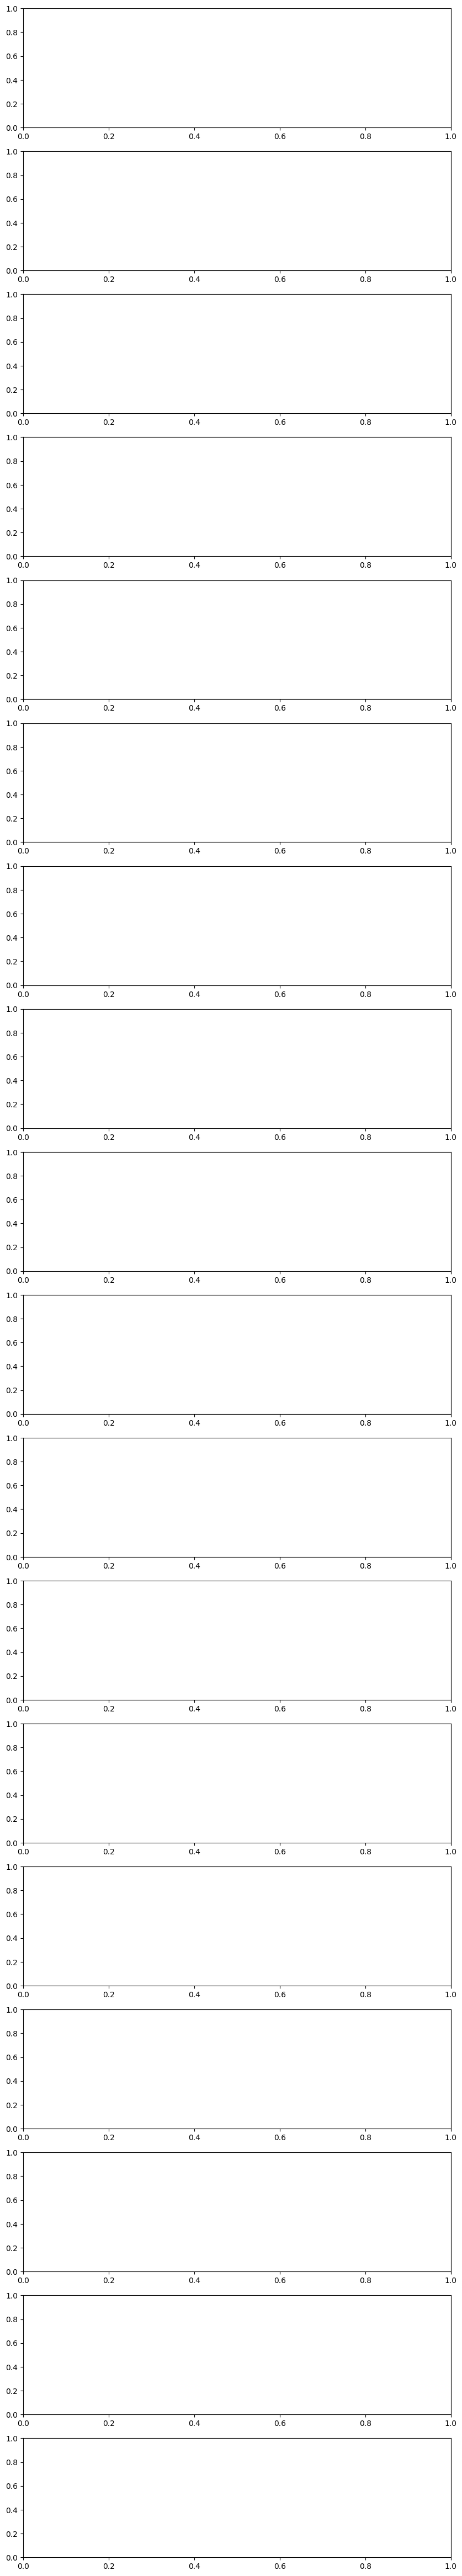

In [7]:
fig, ax = plt.subplots(18,1,figsize=(10,60))
for metric_idx in range(len(PC_df_portion['HR_metric_name'].unique())):
    metric_name = PC_df_portion['HR_metric_name'].unique()[metric_idx]
    data = PC_df_portion[PC_df_portion['HR_metric_name'] == metric_name]
    # HR_location=data['HR_location'].unique()[0]
    sns.lineplot(data = data, x='progress', y='metric_value', hue='App_name', ax = ax[metric_idx], ci=False)
    sns.scatterplot(data = data, x='progress', y='metric_value', hue='App_name', ax = ax[metric_idx], alpha=0.15, legend=False)
    ax[metric_idx].set_title(f"{metric_name}", fontsize=20, loc='right')
    # ax[metric_idx].text(1.05, 1.0, f'Grouped per: \n {HR_location}', transform=ax[metric_idx].transAxes,
    #      ha='left', va='top', fontsize=15)
    ax[metric_idx].grid()
    # ax[metric_idx].set_yscale('log')
    ax[metric_idx].set_xlabel('Session', fontsize=15)
    ax[metric_idx].set_ylabel('Events number', fontsize=15)
    ax[metric_idx].tick_params(axis='x', labelrotation=90, labelsize=13)
    ax[metric_idx].set_ylim(0,100)
    # ax[df_idx].set_xticklabels([])
plt.tight_layout()

KeyError: 'HR_metric_name'

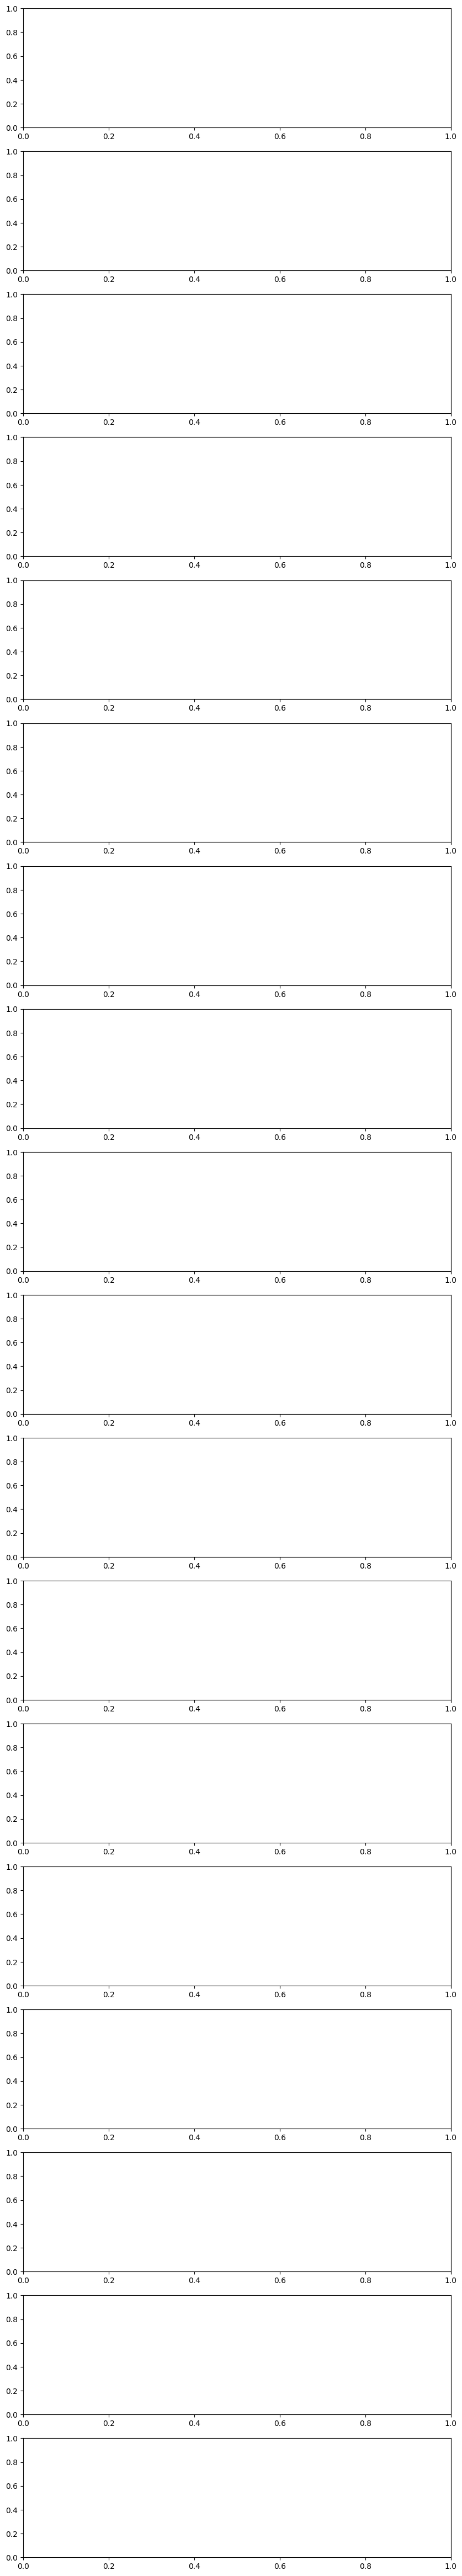

In [9]:
fig, ax = plt.subplots(18,1,figsize=(10,60))
for metric_idx in range(len(PC_df_portion['HR_metric_name'].unique())):
    metric_name = PC_df_portion['HR_metric_name'].unique()[metric_idx]
    data = PC_df_portion[PC_df_portion['HR_metric_name'] == metric_name]
    data = data[data['App_name']=='GPU-burn']
    # HR_location=data['HR_location'].unique()[0]
    sns.lineplot(data = data, x='progress', y='metric_value', ax = ax[metric_idx], ci=False)
    sns.scatterplot(data = data, x='progress', y='metric_value', ax = ax[metric_idx], alpha=0.15, legend=False)
    ax[metric_idx].set_title(f"{metric_name}", fontsize=20, loc='right')
    # ax[metric_idx].text(1.05, 1.0, f'Grouped per: \n {HR_location}', transform=ax[metric_idx].transAxes,
    #      ha='left', va='top', fontsize=15)
    ax[metric_idx].grid()
    # ax[metric_idx].set_yscale('log')
    ax[metric_idx].set_xlabel('Session', fontsize=15)
    ax[metric_idx].set_ylabel('Events number', fontsize=15)
    ax[metric_idx].tick_params(axis='x', labelrotation=90, labelsize=13)
    ax[metric_idx].set_ylim(0,100)
    # ax[df_idx].set_xticklabels([])
plt.tight_layout()

In [39]:
merged_dfs = {}
for key, PC_df in pivot_dfs.items():
    common_cols = set(PC_df.columns).intersection(telemetry_df_portion.columns) - {'progress'}

    telemetry_df_portion_reduced = telemetry_df_portion.drop(columns=common_cols)

    merged_df = pd.merge_asof(
        telemetry_df_portion_reduced.sort_values('progress'),
        PC_df.sort_values('progress'),
        on=['progress'],
        direction='nearest',
        tolerance=1.5
    )

    if key == 'Streaming Multiprocessor':
        merged_df = merged_df[['App_name','temperature_C', 'util_gpu_percent', 'util_mem_percent',
       'mem_used_MB', 'clock_sm_MHz',
       'clock_mem_MHz', 'clock_graphics_MHz',
       'power_draw_W',
       'progress','Integer and Predicate Arithmetic',
       'Number cycles where MIOP PQ sent register operands to a pipeline',
       'Number cycles where the MIO to register file writeback interface was active',
       'Number of cycles where alu pipe was active ',
       'Number of cycles where an SMSP issued an instruction',
       'Number of cycles where fp64 pipe was active',
       'Number of cycles where register operands from the register file were written to MIO PQ',
       'Number of instructions issued from MIOC (Controller) to MIO',
       'Warp instructions executed',
       'Warp instructions executed by Compute Back-End Units pipe with at least 1 thread predicated on',
       'Warp instructions executed by Load Store Units pipe',
       'Warp instructions executed by Texture pipe',
       'Warp instructions executed by adu pipe',
       'Warp instructions executed by uniform pipe']]
    else:
        merged_df = merged_df[['App_name','temperature_C', 'util_gpu_percent', 'util_mem_percent',
       'mem_used_MB', 'clock_sm_MHz',
       'clock_mem_MHz', 'clock_graphics_MHz',
       'power_draw_W',
       'progress','Number of cycles where the IDC processed requests from SM']]
        
    merged_dfs[key]=merged_df

Streaming Multiprocessor
InDexed Constant Cache


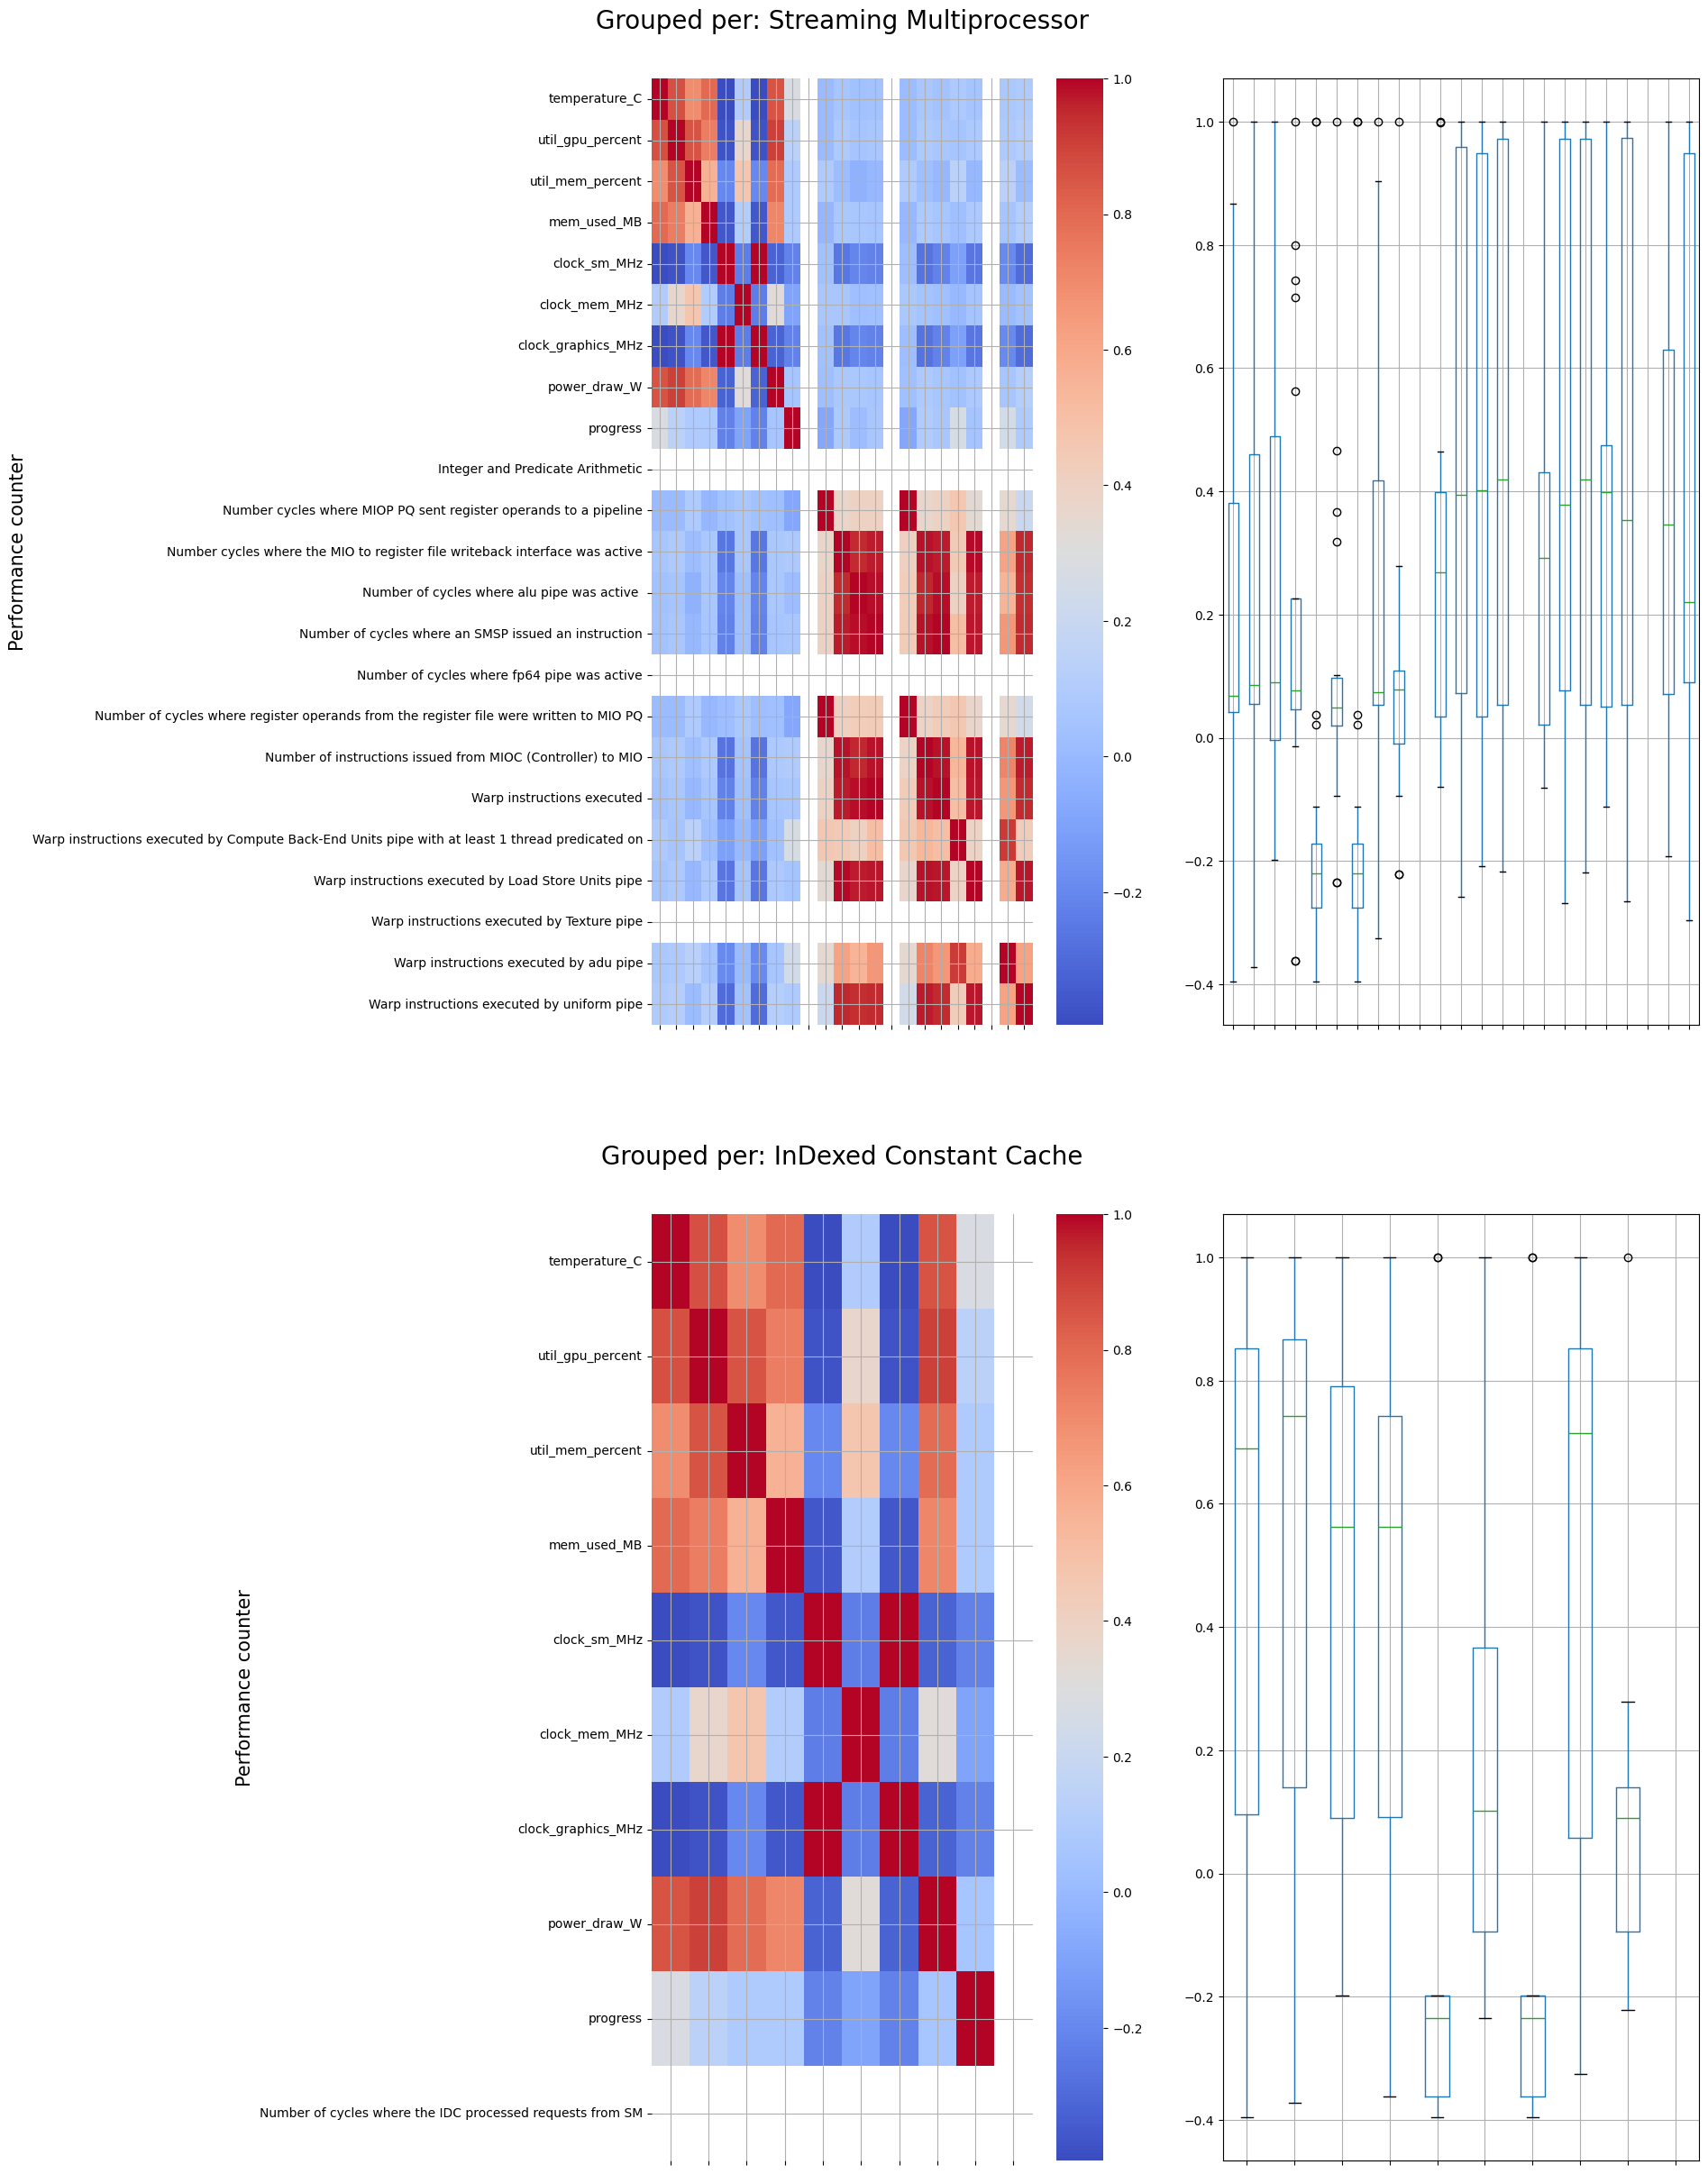

In [53]:
fig, ax = plt.subplots(2,2,figsize=(15,30))
group1 = ['temperature_C', 'util_gpu_percent', 'util_mem_percent', 'mem_used_MB',
       'clock_sm_MHz', 'clock_mem_MHz', 'clock_graphics_MHz', 'power_draw_W']
group2 = []
for pivot_df_idx in range(len(list(merged_dfs.values()))):
    HR_location = list(merged_dfs.keys())[pivot_df_idx]
    print(HR_location)
    if HR_location == 'Streaming Multiprocessor':
        group2=['Number cycles where MIOP PQ sent register operands to a pipeline',
       'Number cycles where the MIO to register file writeback interface was active',
       'Number of cycles where alu pipe was active ',
       'Number of cycles where an SMSP issued an instruction',
       'Number of cycles where fp64 pipe was active',
       'Number of cycles where register operands from the register file were written to MIO PQ',
       'Number of instructions issued from MIOC (Controller) to MIO',
       'Warp instructions executed',
       'Warp instructions executed by Compute Back-End Units pipe with at least 1 thread predicated on',
       'Warp instructions executed by Load Store Units pipe',
       'Warp instructions executed by Texture pipe',
       'Warp instructions executed by adu pipe',
       'Warp instructions executed by uniform pipe']
    else:
        group2 =['Number of cycles where the IDC processed requests from SM']
    data_to_corr = merged_dfs[HR_location][merged_dfs[HR_location]['App_name']=='MobileNetV2'].select_dtypes(include=['float64', 'int64'])
    matrix = data_to_corr.corr()
    matrix.boxplot(ax=ax[pivot_df_idx][1])
    sns.heatmap(matrix, annot=False, cmap='coolwarm', ax=ax[pivot_df_idx][0])
    ax[pivot_df_idx][0].set_title(f"Grouped per: {HR_location}", fontsize=20, pad=40)
    ax[pivot_df_idx][0].grid()
    ax[pivot_df_idx][0].set_xlabel('Performance counter', fontsize=15)
    ax[pivot_df_idx][0].set_ylabel('Performance counter', fontsize=15)
    ax[pivot_df_idx][1].tick_params(axis='x', labelrotation=90, labelsize=13)
    ax[pivot_df_idx][0].tick_params(axis='x', labelrotation=90, labelsize=13)
    ax[pivot_df_idx][0].set_xticklabels([])
    ax[pivot_df_idx][1].set_xticklabels([])
    ax[pivot_df_idx][0].set_xlabel('')

In [8]:
for pivot_df_idx in range(len(list(merged_dfs.values()))):
    HR_location = list(merged_dfs.keys())[pivot_df_idx]
    if HR_location == 'Streaming Multiprocessor':
        group2=['Number cycles where MIOP PQ sent register operands to a pipeline',
       'Number cycles where the MIO to register file writeback interface was active',
       'Number of cycles where alu pipe was active ',
       'Number of cycles where an SMSP issued an instruction',
       'Number of cycles where fp64 pipe was active',
       'Number of cycles where register operands from the register file were written to MIO PQ',
       'Number of instructions issued from MIOC (Controller) to MIO',
       'Warp instructions executed',
       'Warp instructions executed by Compute Back-End Units pipe with at least 1 thread predicated on',
       'Warp instructions executed by Load Store Units pipe',
       'Warp instructions executed by Texture pipe',
       'Warp instructions executed by adu pipe',
       'Warp instructions executed by uniform pipe']
    else:
        group2 =['Number of cycles where the IDC processed requests from SM']
    # print(merged_dfs[HR_location].select_dtypes(include=['float64']))
    # data_to_corr = merged_dfs[HR_location][cols_to_corr]
    # target_data = data_to_corr.drop('HR_location', axis = 1)
    data_to_corr = merged_dfs[HR_location][merged_dfs[HR_location]['App_name']=='MobileNetV2'].select_dtypes(include=['float64', 'int64'])
    # print(data_to_corr[])
    corr_matrix = data_to_corr[group1].corrwith(data_to_corr[group2], axis=0)
    print(corr_matrix)
    break

NameError: name 'merged_dfs' is not defined